# Maximum entropy sampling method based on Gaussian kernel density estimation

In [140]:
import torch
from gaussian_kde import hd_gaussian_kde

def optimize_new_samples(init_action, bandwidth=0.2, num_new_samples=3, 
                         interval=torch.tensor([[-1, 1], ]), learning_rate=8e-2, 
                         num_iterations=200, the_device=None):
    '''
    New data is sampled based on the original data. The new data needs to make the information entropy of the new kernel density as large as possible. The entropy is calculated numerically using the gradient descent method.
    '''
    
    assert len(init_action.shape) == 3, 'action should have 3 dimensions: (batch, m, n)'
    device = the_device if the_device else ('cuda' if torch.cuda.is_available() else 'cpu')
    init_action = init_action.to(device)  # (batch, dim) -> (batch, num=1, dim)
    
    if interval.shape[0] == 1:
        new_samples_init = torch.rand(init_action.shape[0], num_new_samples, device=device) * (interval[0][1] - interval[0][0]) + interval[0][0]
        # new_samples_init = torch.linspace(*interval[0], num_new_samples, device=device).repeat(init_action.shape[0], 1)
        new_samples = new_samples_init.view(new_samples_init.size(0), -1).unsqueeze(-1)
    else:
        interval = interval.to(device)
        linspaces = [torch.linspace(*i_space, num_new_samples, device=device) for i_space in interval]
        grids = torch.meshgrid(*linspaces)
        new_samples = torch.stack(grids, dim=-1).view(-1, len(interval)).unsqueeze(0).repeat(init_action.shape[0], 1, 1)
    
    new_samples = new_samples.requires_grad_()
    optimizer = torch.optim.Adam([new_samples], lr=learning_rate)
    
    density_est_list = []
    
    for i in range(num_iterations):
        optimizer.zero_grad()
        if init_action.shape[-1] > 1:
            action_with_new = torch.cat([init_action, new_samples], dim=1)
        else:
            action_with_new = torch.cat([init_action, new_samples], dim=1)
        grid_values, entropy_with_new, _ = hd_gaussian_kde(action_with_new, interval, bandwidth, device=device)
        density_est_list.append(grid_values)
        loss = -entropy_with_new.mean()
        loss.backward()
        optimizer.step()
        
    with torch.no_grad():
        min_vals = interval[:, 0].unsqueeze(1).to(device)
        max_vals = interval[:, 1].unsqueeze(1).to(device)
        if init_action.shape[-1] == 1:
            new_samples = torch.clamp(new_samples, min=min_vals, max=max_vals).T.transpose(0, -1)
        else:
            for samples_indim, i_interval in zip(range(new_samples.shape[-1]), interval):
                new_samples[:,:,samples_indim] = torch.clamp(new_samples[:,:,samples_indim], *i_interval)
            
    return new_samples.detach(), density_est_list

## High dimensional

2d for example

## Only kernel density estimation

In [167]:
datas = torch.rand([1, 10, 2])  #  for 1 data, the data contain 10 samples with 2d loaction, support mutiple data
data_interval = torch.tensor([[0, 1],
                              [0, 1]])

estimation, entropy, _ = hd_gaussian_kde(datas, data_interval)

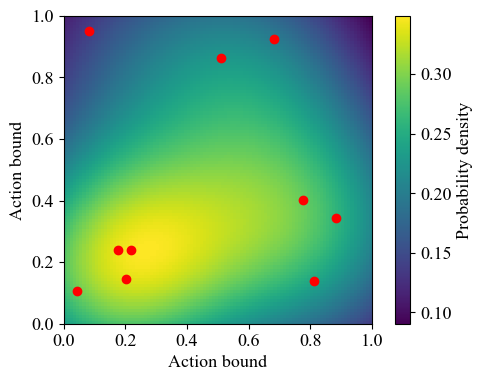

In [168]:
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['font.size'] = 13

plt.figure(figsize=(6, 4))
plt.imshow(estimation[0][1].reshape(100, 100).T, extent=(0, 1, 0, 1), origin='lower', cmap='viridis')
plt.colorbar(label='Probability density')
plt.xlabel('Action bound')
plt.ylabel('Action bound')

# Label the first sample as 'Init' and draw an arrow using `annotate`
plt.scatter(datas[0][:, 0], datas[0][:, 1], color='red', zorder=5)  # 使用蓝色标记原始点

# Sampling

In [171]:
low = torch.tensor([-1, -1])  # If the data is two-dimensional, the minimum value of each dimension is given here, and different ranges are supported
high = torch.tensor([1, 1])  # Same as above
# Generate some random data, where the first dimension is the batch and the second dimension is the data dimension, which is the same length as `low` or `high`
init_data = (low + (high - low) * torch.rand([1, len(low)])).unsqueeze(1)  # 

if len(init_data.shape) != 3:
    init_data = init_data.unsqueeze(1) 
    '''
    ensure three dimension of data: 
    b, m, n = action.shape, where 
    `b` is the batch size, 
    `m` is the number of small samples per sample, 
    and `n` is the dimension of the small samples.
    '''

data_interval = torch.stack((low, high)).T
'''
2d data like:
tensor([[-1,  1],
        [-1,  1]])
'''

new_samples, density_est_list = optimize_new_samples(init_data, interval=data_interval, num_new_samples=3, num_iterations=30, the_device='cpu')
samples_with_new = torch.cat([init_data, new_samples], dim=1)

new_est, new_en, _ = hd_gaussian_kde(samples_with_new, data_interval)  # for visualization
init_est, init_en, _ = hd_gaussian_kde(init_data, data_interval)

Visualization (for 2d data)

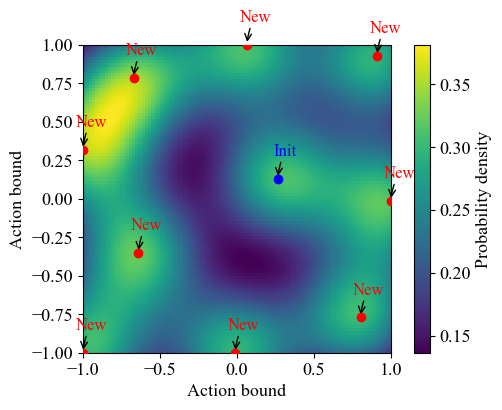

In [172]:
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['font.size'] = 13

plt.figure(figsize=(6, 4))
plt.imshow(new_est[0][1].reshape(100, 100).T, extent=(-1, 1, -1, 1), origin='lower', cmap='viridis')
plt.colorbar(label='Probability density')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.xlabel('Action bound')
plt.ylabel('Action bound')

# Label the first sample as 'Init' and draw an arrow using `annotate`
plt.scatter(samples_with_new[0][:, 0][0], samples_with_new[0][:, 1][0], color='blue', zorder=5)
plt.annotate('Init', xy=(samples_with_new[0][0, 0], samples_with_new[0][0, 1]), 
             xytext=(samples_with_new[0][0, 0] + 0.05, samples_with_new[0][0, 1] + 0.15),
             arrowprops=dict(facecolor='blue', arrowstyle='->', connectionstyle="arc3,rad=0.1", shrinkA=0),
             color='blue', ha='center', fontsize=12)

# Label others sample as 'Init' and draw an arrow using `annotate`
plt.scatter(samples_with_new[0][:, 0][1:], samples_with_new[0][:, 1][1:], color='red', zorder=5)
for i in range(1, samples_with_new[0].shape[0]):
    plt.annotate('New', xy=(samples_with_new[0][i, 0], samples_with_new[0][i, 1]), 
                 xytext=(samples_with_new[0][i, 0] + 0.05, samples_with_new[0][i, 1] + 0.15),
                 arrowprops=dict(facecolor='red', arrowstyle='->', connectionstyle="arc3,rad=0.1", shrinkA=0),
                 color='red', ha='center', fontsize=12)
plt.savefig('image/kde_2d.pdf')
plt.savefig('image/kde_2d.png')
plt.show()

## 1 dimensional

In [177]:
low = torch.tensor([-1, ])
high = torch.tensor([1, ])
init_data = (low + (high - low) * torch.rand([1, len(low)])).unsqueeze(1)

if len(init_data.shape) != 3:
    init_data = init_data.unsqueeze(1)

data_interval = torch.stack((low, high)).T

new_samples, density_est_list = optimize_new_samples(init_data, interval=data_interval, num_new_samples=3, num_iterations=200, learning_rate=0.005, the_device='cpu')
samples_with_new = torch.cat([init_data, new_samples], dim=1)

new_est, new_en, _ = hd_gaussian_kde(samples_with_new, data_interval)
init_est, init_en, _ = hd_gaussian_kde(init_data, data_interval)

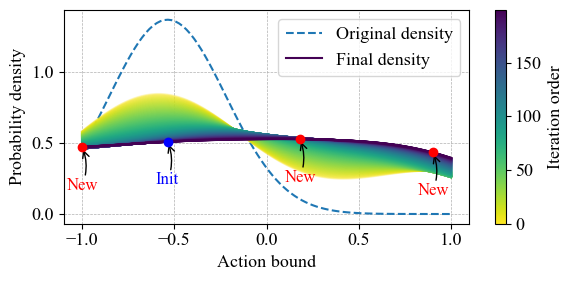

In [178]:
import numpy as np
import matplotlib.pyplot as plt

# Set font “Times New Roman”
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['font.size'] = 13
# Set the color mapping range, from light to dark
cmap = plt.cm.viridis

plt.figure(figsize=(6, 3))
ax = plt.gca()
num_curves = len(density_est_list)
norm = plt.Normalize(vmin=0, vmax=num_curves-1)  # Normalize the color bar

ax.plot(density_est_list[0][0][0], init_est[0][1], linestyle='--', label='Original density')

# 绘制所有密度估计曲线
for i, meta_data in enumerate(density_est_list):
    # 计算颜色和透明度的渐变值
    x_points, density = meta_data[0][0].reshape(-1), meta_data[0][1]
    color_value = 1 - i / (num_curves - 1)  # Reverse gradient: from 1 to 0
    color = cmap(color_value)
    alpha_value = 0.2 + 0.8 * (1 - color_value ** 3)  # Transparency varies from 0.1 to 1
    if i == len(density_est_list)-1:
        label = 'Final density'
    else:
        label = None
    ax.plot(x_points, density, color=color, alpha=alpha_value, label=label)
plt.legend(loc=1)

# Get the value of the last curve and mark the new_samples point
final_density = density_est_list[-1][0][1]

# Mark init data: init_x_samples
for idx, point in enumerate(init_data):
    closest_idx = np.argmin(np.abs(x_points - point.item()))
    y_value = final_density[closest_idx].item()
    ax.scatter(point.item(), y_value, color='blue', zorder=5)
    ax.annotate(f'Init', xy=(point.item(), y_value), xytext=(point.item(), y_value-0.3),
                arrowprops=dict(facecolor='blue', arrowstyle='->', connectionstyle="arc3,rad=0.2", shrinkA=0),
                color='blue', ha='center', fontsize=12)

# 标记新加入的点 new_samples
for idx, point in enumerate(new_samples.detach().cpu()[0]):
    closest_idx = np.argmin(np.abs(x_points - point.item()))
    y_value = final_density[closest_idx].item()
    ax.scatter(point.item(), y_value, color='red', zorder=5)
    ax.annotate(f'New', xy=(point.item(), y_value), xytext=(point.item(), y_value-0.3),
                arrowprops=dict(facecolor='red', arrowstyle='->', connectionstyle="arc3,rad=0.2", shrinkA=0),
                color='red', ha='center', fontsize=12)

# 添加色彩条
sm = plt.cm.ScalarMappable(cmap=cmap.reversed(), norm=norm)
sm.set_array([])  # Just for colorbar, no actual mapping data needed
cbar = plt.colorbar(sm, ax=ax)  # Specifies that a colorbar is added to the current axes
cbar.set_label('Iteration order')

# plt.ylim(0, 0.6)
# plt.title("Kernel density estimation over iterations")
plt.xlabel("Action bound")
plt.ylabel("Probability density")
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig('image/kde_1d.pdf')
plt.savefig('image/kde_1d.png')
plt.show()